## Curate data

#### Read json files

In [9]:
import os
import json
from pathlib import Path
import pandas as pd

# Point to raw data folder
repo_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
raw_dir   = os.path.join(repo_root, "data", "raw")

# List all files
all_files = os.listdir(raw_dir)

# Filter for receipts and items JSON
receipt_files = [f for f in all_files if f.startswith("receipts_") and f.endswith(".json")]
item_files = [f for f in all_files if f.startswith("items_") and f.endswith(".json")] 

# Validate
if not receipt_files:
    raise FileNotFoundError(f"No receipts_*.json found in {raw_dir}")
if not item_files:
    raise FileNotFoundError(f"No items_*.json found in {raw_dir}")

#Read the files 
receipt_filename = receipt_files[0]
item_filename    = item_files[0]

receipt_path = os.path.join(raw_dir, receipt_filename)
item_path    = os.path.join(raw_dir, item_filename)

print("→ Loading receipts from", receipt_filename)
print("→ Loading items    from", item_filename)

# Load them (with UTF-8)
with open(receipt_path, "r", encoding="utf-8") as f:
    receipts = json.load(f)

with open(item_path, "r", encoding="utf-8") as f:
    items = json.load(f)

print(f"✅ Loaded {len(receipts)} receipts, {len(items)} items")


→ Loading receipts from receipts_2025-07.json
→ Loading items    from items_2025-07.json
✅ Loaded 50 receipts, 23 items


#### Create table with desired content

In [22]:
#Transform into a flat table
rows = []
for r in receipts:
    date_time = r["receipt_date"]
    date, time_z = date_time.split("T")
    time = time_z.rstrip("Z")
    payment_types = ";".join(p["type"] for p in r.get("payments", []))

    for line in r.get("line_items", []):
        mods = ";".join(f"{m['name']}({m['option']})"
                        for m in line.get("line_modifiers", [])) or None

        rows.append({
            "receipt_number": r["receipt_number"],
            "date":           date,
            "time":           time,
            "order_type":     r.get("order"),
            "item_name":      line.get("item_name"),
            "cost":           line.get("cost"),
            "price":          line.get("price"),
            "modifiers":      mods,
            "payment_type":   payment_types
        })

df = pd.DataFrame(rows)
print(df.head())

  receipt_number        date          time     order_type       item_name  \
0         1-1653  2025-07-13  03:52:35.000  A domicilio 1     Doble Smash   
1         1-1652  2025-07-13  03:35:12.000         Mesa 1    Smash Burger   
2         1-1652  2025-07-13  03:35:12.000         Mesa 1  Chicken Burger   
3         1-1652  2025-07-13  03:35:12.000         Mesa 1       Coca Cola   
4         1-1651  2025-07-13  03:34:22.000  A domicilio 1     Doble Smash   

   cost  price                                          modifiers payment_type  
0  69.0  125.0     Mayonesa(Ajo);Sin Ingredientes(Sin Pepinillos)         CASH  
1  48.5  100.0  Sin Ingredientes(Sin Pepinillos);Mayonesa(Natu...         CASH  
2  40.0   95.0                                 Mayonesa(Chipotle)         CASH  
3  16.0   25.0                                               None         CASH  
4  69.0  125.0                                      Mayonesa(Ajo)         CASH  


### Quick analysis

In [32]:
df.head()

,receipt_number,date,time,order_type,item_name,cost,price,modifiers,payment_type
0,1-1653,2025-07-13,03:52:35.000,A domicilio 1,Doble Smash,69.0,125.0,Mayonesa(Ajo);Sin Ingredientes(Sin Pepinillos),CASH
1,1-1652,2025-07-13,03:35:12.000,Mesa 1,Smash Burger,48.5,100.0,Sin Ingredientes(Sin Pepinillos);Mayonesa(Natu...,CASH
2,1-1652,2025-07-13,03:35:12.000,Mesa 1,Chicken Burger,40.0,95.0,Mayonesa(Chipotle),CASH
3,1-1652,2025-07-13,03:35:12.000,Mesa 1,Coca Cola,16.0,25.0,None,CASH
4,1-1651,2025-07-13,03:34:22.000,A domicilio 1,Doble Smash,69.0,125.0,Mayonesa(Ajo),CASH


### See all order_types

In [18]:
types = df["order_type"].unique()
print(types)

['A domicilio 1' 'Mesa 1' 'Para Llevar 1' 'Mesa 3' 'Para Llevar 2'
 'A domicilio 2' 'Mesa 4' '01-636' 'Mesa 2 - 1' 'Mesa 2 - 1 - 1' '01-624'
 '01-620' '01-619' 'Mesa 2' 'Mesa 5']


### Get a peak of whats in the non expected values

In [25]:
non_expected = df[df["order_type"] == "01-619"]
non_expected.head()

,receipt_number,date,time,order_type,item_name,cost,price,modifiers,payment_type
88,1-1615,2025-07-09,01:28:49.000,01-619,Smash Burger,48.5,100.0,Mayonesa(Natural),CASH


### Lets be sure the non expected values appears once for each receipt

In [33]:
import matplotlib.pyplot as plt
order_item = df.groupby("receipt_number")["order_type"]

unique_counts = order_item.nunique()

nunique_counts = unique_counts[unique_counts > 1]
print(nunique_counts)

Series([], Name: order_type, dtype: int64)


### Lets clean this data

In [ ]:
#Renames the numbered order_types
cleaned_data = df.copy()
condition = cleaned_data["order_type"].str.contains("01" ,na=False)

cleaned_data.loc[condition, "order_type"] = "Para Llevar"

#Renames the Mesa - order_type
condition_mesa = cleaned_data["order_type"].str.contains("-" ,na=False)

cleaned_data.loc[condition_mesa,"order_type"] = "Mesa 2"


Empty DataFrame
Columns: [receipt_number, date, time, order_type, item_name, cost, price, modifiers, payment_type]
Index: []


#### Now lets homogenize the names

In [61]:
#Homogenize by condition
condition = cleaned_data["order_type"].str.contains("domicilio",na=False)
cleaned_data.loc[condition,"order_type"] = "A domicilio"

condition = cleaned_data["order_type"].str.contains("Llevar",na=False)
cleaned_data.loc[condition,"order_type"] = "Para llevar"

<Axes: xlabel='order_type'>

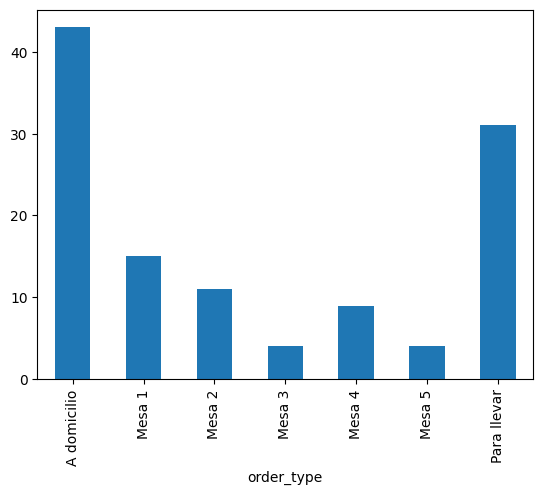

In [62]:
types = cleaned_data.groupby("order_type")["item_name"].count()

types.plot(kind="bar")

#### Finally lets give a more usable format to the timestamp

In [88]:
# Lets classify timestamps by half hours

# --- Main Logic ---

# 1. Ensure the column is a proper time object)

cleaned_data['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype())

cleaned_data["shifted_time"] = cleaned_data["datetime"] + pd.to_timedelta(17, unit = 'h')

#cleaned_data["shifted_time"] = pd.to_datetime(cleaned_data["shifted_time"]).dt.time

# 2. Create a numerical column (minutes past midnight) for binning
cleaned_data['minutes_past_midnight'] = cleaned_data['shifted_time'].apply(lambda t: t.hour * 60 + t.minute)

# 3. Define the time intervals (bins) in 1 hour increments for a full day
bins = range(0, 24 * 60 + 1, 60) 

# 4. Create labels for each interval (e.g., "01:30-01:45")
labels = [f"{i//60:02d}:00-{(i+60)//60:02d}:00" for i in bins[:-1]]

# 5. Create the new column using pd.cut
cleaned_data['time_slot'] = pd.cut(cleaned_data['minutes_past_midnight'],
                         bins=bins,
                         labels=labels,
                         right=False,      # Intervals are [left, right), e.g., includes 1:30 but not 1:45
                         include_lowest=True)



print(df[['time', 'time_slot',"shifted_time_slot"]].sort_values("time_slot"))


TypeError: NDFrame.astype() missing 1 required positional argument: 'dtype'

#### Lets see the added column

C:\Users\abner\AppData\Local\Temp\ipykernel_22676\3535579954.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sold_by_time = df.groupby("time_slot")["receipt_number"].count()


<Axes: xlabel='time_slot'>

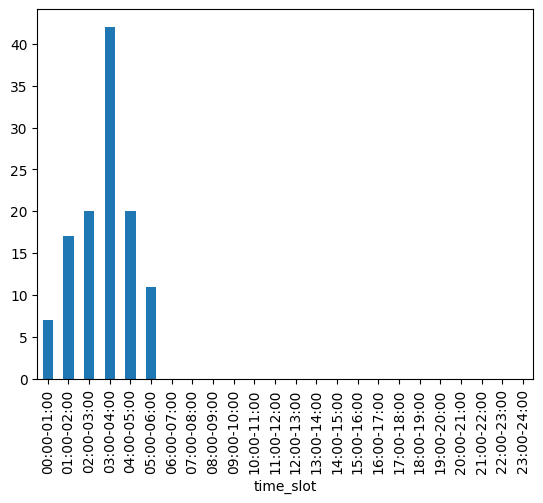

In [79]:
sold_by_time = df.groupby("time_slot")["receipt_number"].count()

sold_by_time.plot(kind="bar")